In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt


In [11]:
print(tf.config.list_physical_devices('gpu2'))
print(tf.test.is_gpu_available())

[]
False


In [12]:
# Define directories
mainDir = 'D:\DATA IJA\Semester 6\ML\lego2\lego2\The IQ-OTHNCCD lung cancer dataset'
# mainDir = 'dataset/train'
# validation_dir = 'dataset/validation'
# test_dir = 'dataset/test'
batch_size = 32


# Create ImageDataGenerator instances for training, validation, and test sets
# Original Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


# validation_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\PLN\AppData\Local\Temp\ipykernel_14612\3915792482.py:2: SyntaxWarning: invalid escape sequence '\D'
  mainDir = 'D:\DATA IJA\Semester 6\ML\lego2\lego2\The IQ-OTHNCCD lung cancer dataset'


In [13]:
train_generator = train_datagen.flow_from_directory(
    mainDir,
    target_size=(128, 128),  # Reduced target size
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Specify grayscale input here
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    mainDir,
    target_size=(128, 128),  # Reduced target size
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Specify grayscale input here
    subset='validation'
)

Found 878 images belonging to 3 classes.


Found 219 images belonging to 3 classes.


In [14]:
# Function to extract data and labels from generator
def extract_data(generator):
    data = []
    labels = []
    for i in range(len(generator)):
        x, y = next(generator)
        data.extend(x)
        labels.extend(y)
    return np.array(data), np.array(labels)

# Extract training data and labels
X_train, y_train = extract_data(train_generator)
X_val, y_val = extract_data(validation_generator)

In [15]:
# Reshape data to 2D
nsamples, nx, ny, nz = X_train.shape
X_train_reshaped = X_train.reshape((nsamples, nx*ny*nz))

# Apply SMOTE to the training data
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train, axis=1))

# Reshape back to original shape
X_resampled = X_resampled.reshape((X_resampled.shape[0], nx, ny, nz))
y_resampled = tf.keras.utils.to_categorical(y_resampled, num_classes=3)

# Verify class distribution after SMote
print(f"Class distribution before SMOTE: {Counter(np.argmax(y_train, axis=1))}")
print(f"Class distribution after SMOTE: {Counter(np.argmax(y_resampled, axis=1))}")

Class distribution before SMOTE: Counter({1: 449, 2: 333, 0: 96})
Class distribution after SMOTE: Counter({2: 449, 1: 449, 0: 449})


In [16]:
# Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

c:\Users\PLN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 126, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 61, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,217,539 (50.42 MB)

 Trainable params: 13,216,643 (50.42 MB)

 Non-trainable params: 896 (3.50 KB)

In [18]:

# Train the model with resampled data
history = model.fit(
    X_resampled, y_resampled,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
)

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4927 - loss: 71.1898 - val_accuracy: 0.1096 - val_loss: 66.3092 - learning_rate: 1.0000e-04
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7770 - loss: 59.5220 - val_accuracy: 0.1096 - val_loss: 58.8419 - learning_rate: 1.0000e-04
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8134 - loss: 48.5876 - val_accuracy: 0.1096 - val_loss: 50.8549 - learning_rate: 1.0000e-04
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8717 - loss: 38.9867 - val_accuracy: 0.1096 - val_loss: 44.9114 - learning_rate: 1.0000e-04
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8992 - loss: 31.1856 - val_accuracy: 0.1096 - val_loss: 38.8136 - learning_rate: 1.0000e-04
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9275 - loss: 24.9138 - val_accuracy: 0.1096 - val_loss: 32.1310 - learning_rate: 1.0000e-04
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accur

In [24]:
loss, accuracy = model.evaluate(X_train, y_train)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')



28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 394ms/step - accuracy: 1.0000 - loss: 1.1660
Loss: 1.1650574207305908
Accuracy: 1.0


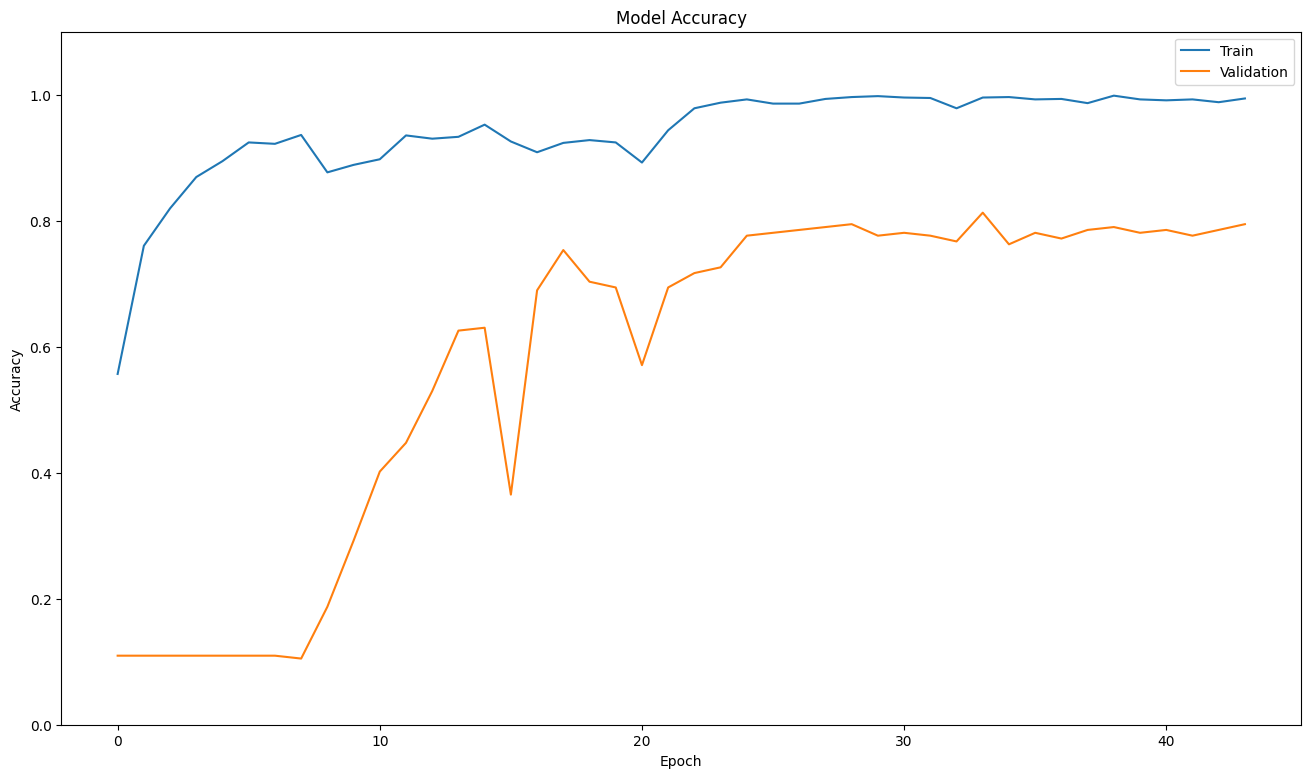

In [20]:
def plot_hist_Accuracy(hist):
    plt.figure(figsize=(16, 9))
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc = "upper right")
    plt.ylim(0,1.1)
    plt.show()

plot_hist_Accuracy(history)


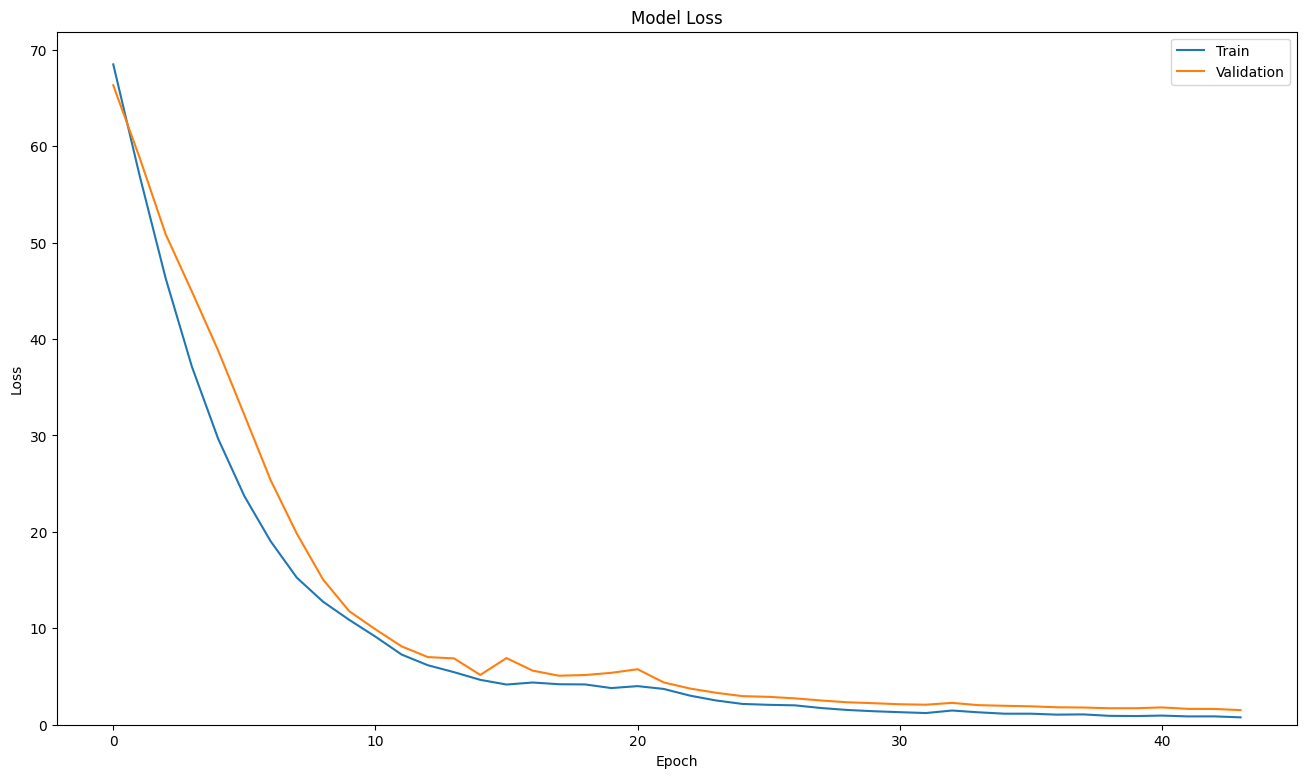

In [21]:
def plot_hist_loss(hist):
    plt.figure(figsize=(16, 9))
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(["Train", "Validation"], loc = "upper right")
    plt.ylim(0,)
    plt.show()

plot_hist_loss(history)